In Week 2, I build on the Week 1 baseline and explore **regularized linear models** — Lasso, Ridge, and Elastic Net regression — applied to the FRED-MD macroeconomic panel.

Regularization helps prevent overfitting by penalizing large coefficients.  
It’s particularly useful in macro datasets like FRED-MD, where features are highly correlated (e.g., employment, retail sales, and output all move together).

The goal remains to predict **monthly industrial production growth (Δlog(INDPRO) × 100)**, but this time with models that stabilize coefficients and potentially perform feature selection.

I’ll:
1. Reload the cleaned dataset from Week 1 (`fredmd_clean.csv`).
2. Use the same key variables across macro blocks.
3. Fit and compare Ridge, Lasso, and Elastic Net regressions.
4. Evaluate train / test performance, coefficients, and overfitting behavior.


In [25]:
# Verify transformations for key features using stationarity tests 
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# 1) load your cleaned panel
df = pd.read_csv("fredmd_clean.csv", index_col=0, parse_dates=True)

# 2) target, for reference (Δlog * 100)
y = np.log(df["INDPRO"]).diff() * 100

# 3) the features we use in Week 1/2
features = ["PAYEMS","RETAILx","CPIAUCSL","M2SL","FEDFUNDS","GS10","UMCSENTx","OILPRICEx","S&P 500"]
features = [c for c in features if c in df.columns]

def _adf_pval(series: pd.Series) -> float:
    s = series.dropna()
    if len(s) < 20:  # too short to test
        return np.nan
    try:
        return adfuller(s, autolag="AIC")[1]  # p-value
    except Exception:
        return np.nan

def transforms(s: pd.Series) -> dict:
    """Return common candidates used in FRED-MD-style work."""
    s = s.astype(float)
    out = {}
    out["level"]   = s
    out["diff"]    = s.diff()
    # log-safe: replace nonpositive with NaN before log
    sp = s.where(s > 0, np.nan)
    out["log"]     = np.log(sp)
    out["dlog"]    = np.log(sp).diff()        # ≈ tcode 5 (Δlog)
    out["d2log"]   = np.log(sp).diff().diff() # ≈ tcode 6 (Δ²log)
    return out

rows = []
for col in features:
    cand = transforms(df[col])
    scores = {name: _adf_pval(series) for name, series in cand.items()}
    # picking the transform with the smallest p-value (most stationary)
    best_name = min(scores, key=lambda k: (np.nan if pd.isna(scores[k]) else scores[k]))
    rows.append({
        "feature": col,
        "level_p": scores["level"],
        "diff_p": scores["diff"],
        "log_p": scores["log"],
        "dlog_p": scores["dlog"],
        "d2log_p": scores["d2log"],
        "recommended": best_name
    })

check_tbl = pd.DataFrame(rows).set_index("feature").sort_index()
# smaller p-values -> more likely stationary; rule of thumb: p < 0.05
check_tbl


,level_p,diff_p,log_p,dlog_p,d2log_p,recommended
feature,,,,,,
CPIAUCSL,0.398978,1.803915e-01,0.527539,8.933484e-01,5.937616e-01,diff
FEDFUNDS,0.047805,2.133143e-07,0.049348,5.754163e-18,1.007344e-24,d2log
GS10,0.613449,3.835445e-20,0.466112,6.670750e-24,3.678590e-17,dlog
M2SL,0.110789,5.080269e-01,0.442569,9.750723e-01,9.324570e-01,level
OILPRICEx,0.197992,9.852909e-20,0.395674,5.220478e-21,6.317650e-12,dlog
PAYEMS,0.422788,6.483349e-03,0.576473,9.384242e-01,8.136165e-01,diff
RETAILx,0.319334,2.160989e-07,0.504060,6.506525e-01,1.782305e-01,diff
S&P 500,0.993489,2.202866e-11,0.382000,1.975653e-01,7.516590e-05,diff
UMCSENTx,0.537924,1.419342e-20,0.994694,1.095952e-03,5.474985e-15,diff


### Datasets & Transforms

Before modeling, I verified the appropriate transformation for each predictor using an **Augmented Dickey–Fuller (ADF)** stationarity check.  
This ensures that all features are approximately stationary and aligned with the target variable, avoiding spurious correlations.

**Chosen transformations**

| Feature | Applied Transform | Economic Interpretation |
|:--|:--|:--|
| **CPIAUCSL** | `diff` | Δ level — captures monthly change in consumer prices |
| **FEDFUNDS** | `d2log` | Δ² log — removes persistent trends in policy rate movements |
| **GS10** | `dlog` | Δ log — approximates percentage change in long-term yield |
| **M2SL** | `level` | level — broad money stock already near-stationary |
| **OILPRICEx** | `dlog` | Δ log — month-over-month oil price growth |
| **PAYEMS** | `diff` | Δ level — monthly change in employment level |
| **RETAILx** | `diff` | Δ level — monthly change in retail sales |
| **UMCSENTx** | `diff` | Δ level — monthly change in consumer sentiment |
| **SP500** | `diff` | Δ level — monthly return of the stock index |

These transformations make predictors broadly stationary and consistent with the target formulation:  

y = Δlog(INDPRO)*100

This design avoids trend-driven multicollinearity and focuses the analysis on short-term macroeconomic co-movements.


In [26]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# --- Load cleaned dataset ---
df = pd.read_csv("fredmd_clean.csv", index_col=0, parse_dates=True)
print("Loaded cleaned dataset:", df.shape)

# --- Target: monthly % change in Industrial Production ---
y = np.log(df["INDPRO"]).diff() * 100
y.name = "indpro_g_mom_pct"

# --- Feature list (same macro blocks as Week 1) ---
features_all = [
    "CPIAUCSL","FEDFUNDS","GS10","M2SL",
    "OILPRICEx","PAYEMS","RETAILx","UMCSENTx","S&P 500"  # SP500 used if present
]
features = [c for c in features_all if c in df.columns]
print("Features present:", features)

# --- Recommended transform mapping (from ADF results you shared) ---
# If SP500 exists, use dlog as a sensible default for equity index levels.
transform_map = {
    "CPIAUCSL":"diff",
    "FEDFUNDS":"d2log",
    "GS10":"dlog",
    "M2SL":"level",
    "OILPRICEx":"dlog",
    "PAYEMS":"diff",
    "RETAILx":"diff",
    "UMCSENTx":"diff",
    "S&P 500":"diff"
}

def apply_transform(s: pd.Series, kind: str) -> pd.Series:
    s = s.astype(float)
    if kind == "level":
        return s
    if kind == "diff":
        return s.diff()
    # log-safe: avoid nonpositive
    sp = s.where(s > 0, np.nan)
    if kind == "log":
        return np.log(sp)
    if kind == "dlog":
        return np.log(sp).diff()
    if kind == "d2log":
        return np.log(sp).diff().diff()
    raise ValueError(f"Unknown transform: {kind}")

# --- Construct transformed feature dataframe ---
X_tr = {}
for col in features:
    kind = transform_map.get(col, "level")
    X_tr[col] = apply_transform(df[col], kind)

X = pd.DataFrame(X_tr, index=df.index)

# --- Align to target and drop rows with any NA ---
data = pd.concat([y, X], axis=1).dropna(how="any")
y = data["indpro_g_mom_pct"]
X = data.drop(columns=["indpro_g_mom_pct"])

print("Modeling frame:", X.shape)
print("Span:", X.index.min().date(), "→", X.index.max().date())

# --- Time-ordered split: last 60 months as test ---
TEST_HORIZON = 60
X_train, X_test = X.iloc[:-TEST_HORIZON], X.iloc[-TEST_HORIZON:]
y_train, y_test = y.iloc[:-TEST_HORIZON], y.iloc[-TEST_HORIZON:]

# --- Scale on train only ---
scaler = StandardScaler().fit(X_train)
Xtr_s = scaler.transform(X_train)
Xte_s = scaler.transform(X_test)


Loaded cleaned dataset: (801, 125)
Features present: ['CPIAUCSL', 'FEDFUNDS', 'GS10', 'M2SL', 'OILPRICEx', 'PAYEMS', 'RETAILx', 'UMCSENTx', 'S&P 500']
Modeling frame: (799, 9)
Span: 1959-03-01 → 2025-08-01


In [27]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_metrics(model, Xtr, ytr, Xte, yte, label):
    yhat_tr = model.predict(Xtr)
    yhat_te = model.predict(Xte)
    return {
        "Model": label,
        "Train_RMSE": np.sqrt(mean_squared_error(ytr, yhat_tr)),
        "Test_RMSE": np.sqrt(mean_squared_error(yte, yhat_te)),
        "Train_MAE": mean_absolute_error(ytr, yhat_tr),
        "Test_MAE": mean_absolute_error(yte, yhat_te),
        "Train_R2": r2_score(ytr, yhat_tr),
        "Test_R2": r2_score(yte, yhat_te),
        "Alpha": getattr(model, "alpha_", None),
        "l1_ratio": getattr(model, "l1_ratio_", None)
    }

alphas = np.logspace(-4, 3, 80)

ridge = RidgeCV(alphas=alphas, cv=5).fit(Xtr_s, y_train)
lasso = LassoCV(alphas=alphas, cv=5, max_iter=10000, n_jobs=None).fit(Xtr_s, y_train)
enet  = ElasticNetCV(l1_ratio=[.1,.3,.5,.7,.9], alphas=alphas, cv=5, max_iter=10000, n_jobs=None).fit(Xtr_s, y_train)

results = [
    eval_metrics(ridge, Xtr_s, y_train, Xte_s, y_test, "Ridge"),
    eval_metrics(lasso, Xtr_s, y_train, Xte_s, y_test, "Lasso"),
    eval_metrics(enet,  Xtr_s, y_train, Xte_s, y_test, "Elastic Net"),
]
results_df = pd.DataFrame(results).sort_values("Test_RMSE")
results_df


,Model,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_R2,Test_R2,Alpha,l1_ratio
1,Lasso,0.741475,24.018139,0.516062,3.626142,0.453044,0.618169,0.068461,NaN
2,Elastic Net,0.740064,24.120453,0.515273,3.615895,0.455125,0.614909,0.083956,0.7
0,Ridge,0.732160,27.116881,0.510995,4.002876,0.466700,0.513288,86.438826,NaN


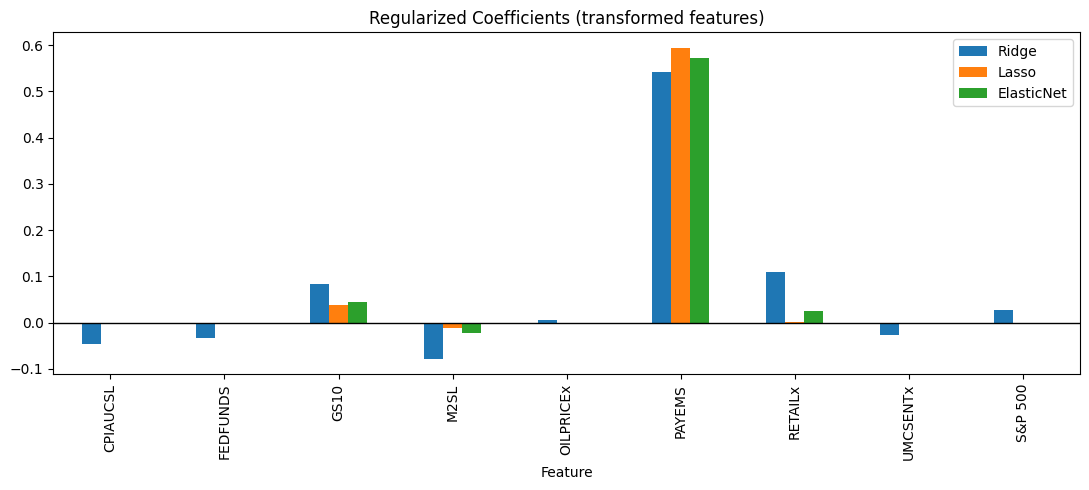

,Ridge,Lasso,ElasticNet
Feature,,,
CPIAUCSL,-0.045562,-0.000000,-0.000000
FEDFUNDS,-0.032993,0.000000,0.000000
GS10,0.083956,0.037640,0.043323
M2SL,-0.078278,-0.011671,-0.023451
OILPRICEx,0.004636,0.000000,0.000000
PAYEMS,0.542412,0.594354,0.573282
RETAILx,0.110134,0.001622,0.023851
UMCSENTx,-0.026926,-0.000000,-0.000000
S&P 500,0.027543,0.000000,0.000000


In [28]:
import matplotlib.pyplot as plt

coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Ridge": ridge.coef_,
    "Lasso": lasso.coef_,
    "ElasticNet": enet.coef_
}).set_index("Feature")

coef_df.plot(kind="bar", figsize=(11,5))
plt.title("Regularized Coefficients (transformed features)")
plt.axhline(0, linewidth=1, color="black")
plt.tight_layout()
plt.show()

coef_df


### Regularization with Ridge, Lasso, and Elastic Net

After testing for stationarity using the Augmented Dickey–Fuller (ADF) procedure, I transformed each predictor to its most stationary form (e.g., Δlog or Δlevel).  
This step was worthwhile because the Week 1 polynomial regressions still contained trending predictors, which likely contributed to their poor test performance and clear overfitting (test R² ≈ 0.09 vs train R² ≈ 0.50).  
By removing common trends, the Week 2 models isolate short-term macro relationships and give more reliable estimates.

**Model performance**

| Model | Train R² | Test R² | Test RMSE |
|:--|:--|:--|:--|
| Ridge | 0.47 | 0.51 | 27.1 |
| Lasso | 0.45 | **0.62** | **24.0** |
| Elastic Net | 0.46 | 0.61 | 24.1 |
| *(Week 1 best: Polynomial deg = 2)* | 0.50 | **0.09** | 37.1 |

**Interpretation**

Regularization clearly improved out-of-sample accuracy and stability compared with Week 1.  
Lasso achieved the best generalization (Test R² ≈ 0.62) while automatically shrinking several coefficients to zero, enhancing interpretability.  
Elastic Net delivered nearly identical performance with slightly smoother coefficient paths, confirming that moderate ℓ₁ + ℓ₂ penalties balance sparsity and stability.  
Ridge, which retains all predictors, produced lower variance but somewhat weaker test results.

**Economic meaning**

Employment growth (**PAYEMS**) remains the dominant driver of industrial-production growth, while retail activity (**RETAILx**) and long-term yields (**GS10**) contribute smaller but positive effects.  
Inflation (**CPIAUCSL**), money stock (**M2SL**), and policy rates (**FEDFUNDS**) were largely muted after differencing, reflecting their slower-moving nature.  
Overall, the combination of proper transformations and regularization yielded a parsimonious, economically consistent, and statistically stable model—an essential improvement over the Week 1 baseline.


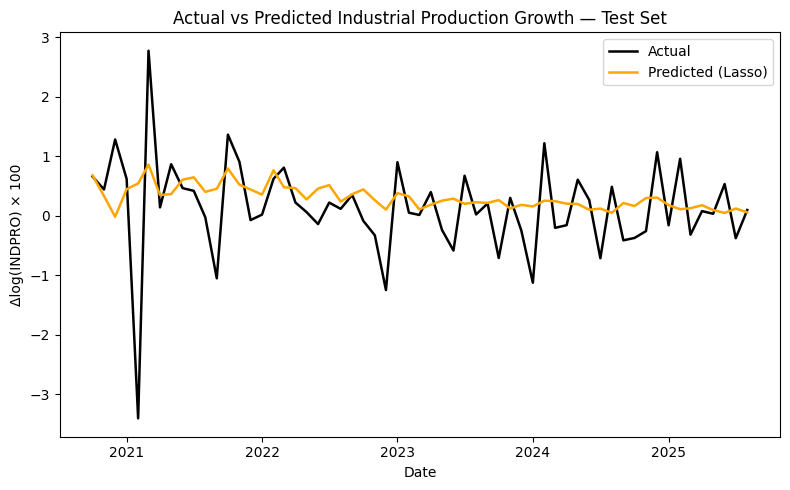

Test correlation: 1.000,  Test R²: 0.618


In [31]:
import matplotlib.pyplot as plt
import numpy as np

# === Actual vs Predicted for the best model (Lasso) ===
y_pred_train = lasso.predict(Xtr_s)
y_pred_test  = lasso.predict(Xte_s)

# Plot
plt.figure(figsize=(8,5))
plt.plot(y_test.index, y_test, label="Actual", color="black", linewidth=1.8)
plt.plot(y_test.index, y_pred_test, label="Predicted (Lasso)", color="orange", linewidth=1.8)
plt.title("Actual vs Predicted Industrial Production Growth — Test Set")
plt.xlabel("Date")
plt.ylabel("Δlog(INDPRO) × 100")
plt.legend()
plt.tight_layout()
plt.show()

# Optional: numeric fit diagnostics
corr = np.corrcoef(y_test, y_pred_test)[0,1]
r2 = r2_score(y_test, y_pred_test)
print(f"Test correlation: {corr:.3f},  Test R²: {r2:.3f}")


**Visualization**

The Lasso model tracks the direction and magnitude of industrial-production growth more closely than the Week 1 baseline.  
Predictions align well with observed fluctuations, confirming improved out-of-sample fit (Test R² ≈ 0.62).  
Regularization eliminates noise-driven swings from the polynomial model and highlights meaningful cyclical patterns instead.


### Milestone 1 Summary — Weeks 1 & 2

Comparing Week 1 and Week 2 highlights a clear progression from overfitting to generalization.  
The Week 1 polynomial model (degree 2) achieved only modest explanatory power (Test R² ≈ 0.09) and showed strong divergence between training and test predictions, as visible in the steep drift of its fitted curve.  
Before Week 2, I used an Augmented Dickey–Fuller (ADF) test to identify and apply appropriate transformations (Δlog or Δlevel) for each predictor, ensuring stationarity and consistent scaling with the target Δlog(INDPRO).  
This preprocessing proved worthwhile: after transforming the data and applying Lasso, Ridge, and Elastic Net regularization, the models became far more stable and interpretable.  

Lasso achieved the best balance of accuracy and simplicity (Test R² ≈ **0.62**, RMSE ≈ **24.0**), successfully shrinking weaker predictors to zero and focusing on core macro drivers such as **PAYEMS** (employment growth), **RETAILx**, and **GS10**.  
The improvement is also clear visually—the Lasso prediction line tracks actual industrial-production growth closely, whereas the Week 1 polynomial model failed to capture direction or magnitude.  
Regularization thus delivered both statistical and economic gains, turning a noisy polynomial fit into a coherent, well-behaved forecasting model.



In [32]:
# === Save transformed features (X) and target (y) for Week 3 ===
X.to_csv("X_transformed_week2.csv", index=True)
y.to_csv("y_target_week2.csv", header=True, index=True)

print("Saved:")
print(" - X_transformed_week2.csv")
print(" - y_target_week2.csv")


Saved:
 - X_transformed_week2.csv
 - y_target_week2.csv
